In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
#file name
fname="test.tsv"
#assay date & name
asname="21xxxx_dna-dye"

#the information about what you want to measure (dna or protein)
#absorbance max
mol_wl=260
#extinction coefficient
mol_coef=230364
#correction factor for tag
#if not needed, please enter '0'
mol_cf=0

#the information about what you want to measure together with other molecule (dna or protein)
#absorbance max
tag_wl=500
#extinction coefficient
tag_coef=90000
#correction factor for tag
#if not needed, please enter '0'
tag_cf=0.22

#pathlength of nanodrop
pl=0.1

In [3]:
test=[]
with open(fname) as file:
    tsv_file=csv.reader(file,delimiter='\t')
    for line in tsv_file:
        test.append(line)
        
num=int((test.count([])/2)+1)
if num==1:
    line_num=len(test)
else:
    line_num=test.index([])

data=[]
for i in range(num):
    data.append(test[i*(line_num+2):line_num+i*(line_num+2)])

dfs=[]
for i in range(num):
    df=pd.DataFrame(data[i])
    df.columns=[data[i][2][0],data[i][0][0]]
    df=df.drop(df.index[0:3])
    df=df.astype({data[i][2][0]:int,
                  data[i][0][0]:np.float})
    dfs.append(df)
    if i>0:
        dfs[i].drop(data[i][2][0],axis='columns',inplace=True)

result=pd.concat(dfs,axis=1)
result=result.reset_index(drop=True)

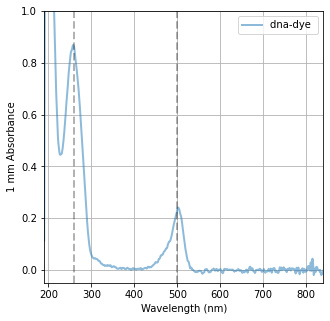

In [4]:
fig, ax=plt.subplots(figsize=(5,5))
x=result.loc[:,['Wavelength (nm)']]

yval=result.drop(['Wavelength (nm)'],axis=1)

for i in yval.columns:
    y=yval.loc[:,[i]]
    ax.plot(x,y,label=i, alpha=0.5, linewidth=2)

#line
plt.axvline(mol_wl, color='black', linestyle='--', linewidth=2, alpha=0.3)
plt.axvline(tag_wl, color='black', linestyle='--', linewidth=2, alpha=0.3)

plt.ylim (-0.05,1)
plt.xlim (190,840)
plt.xlabel('Wavelength (nm)')
plt.ylabel('1 mm Absorbance')
plt.legend()
plt.grid(True)
plt.savefig(asname+'.png')
plt.show()

In [5]:
mol_data=[]
for l in yval.columns:
    mol_data.append(yval.loc[mol_wl-x.loc[0][0],[l]].values)

if tag_wl>0:
    tag_data=[]
    for j in yval.columns:
        tag_data.append(yval.loc[tag_wl-x.loc[0][0],[j]].values)

def cal(a,b,c,d,e):
    return (a-(b*c))/d/e*1000000

mol_conc=[]
if tag_wl>0:
    for m in range(num):
        mol_conc.append(cal(mol_data[m],tag_data[m],tag_cf,mol_coef,pl))
else:
    for m in range(num):
        mol_conc.append(cal(mol_data[m],0,tag_cf,mol_coef,pl))

if tag_wl>0:
    tag_conc=[]
    for k in range(num):
        tag_conc.append(cal(tag_data[k],mol_data[k],mol_cf,tag_coef,pl))

def eff(a,b):
    return (a/b*100)

if tag_wl>0:
    label_eff=[]
    for n in range(num):
        label_eff.append(eff(tag_conc[n],mol_conc[n]))


final_mol=pd.DataFrame(mol_conc,index=yval.columns.values,columns=['Molecule conc.(µM)'])
if tag_wl>0:
    final_tag=pd.DataFrame(tag_conc,index=yval.columns.values,columns=['tag conc.(µM)'])
    final_eff=pd.DataFrame(label_eff,index=yval.columns.values,columns=['Labeling efficiency(%)'])

if tag_wl>0:
    final=final_mol.merge(final_tag,left_index=True,
                          right_index=True).merge(final_eff,
                                                  left_index=True,right_index=True)
else:
    final=final_mol
final.to_csv(asname+'_final.csv',encoding='utf-8')
final

,Molecule conc.(µM),tag conc.(µM),Labeling efficiency(%)
dna-dye,34.986369,25.777778,73.679488
